<a href="https://colab.research.google.com/github/ayachiii/Flow_study/blob/main/pli_hrv_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 本文の考察4.2の結果出力に使用したコードである。

PLIの平均値の各フェーズにおける推移

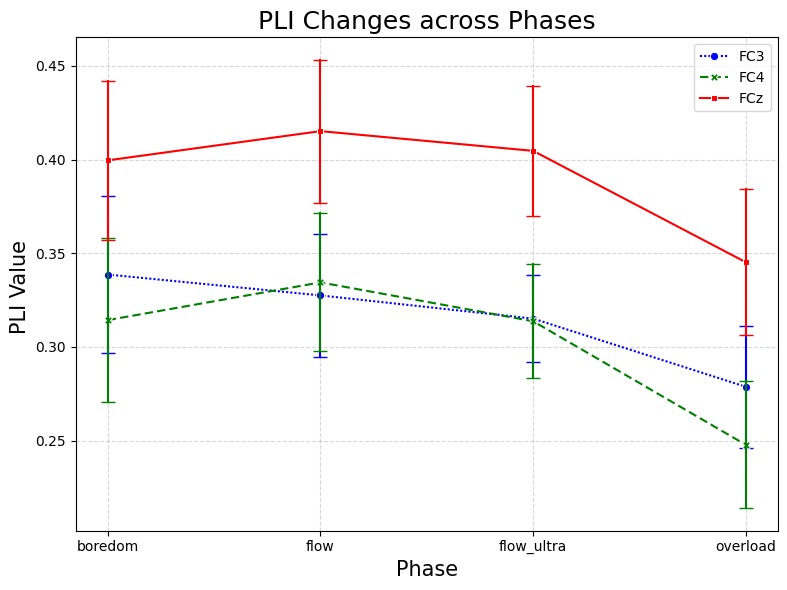

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = 'all_pli_data.csv'
# 欠損値があれば削除
df = pd.read_csv(file_path).dropna()


df.columns = [c.strip() for c in df.columns]


phase_order = ['boredom', 'flow', 'flow_ultra', 'overload']


df = df[df['Phase'].isin(phase_order)]


df_melted = df.melt(id_vars=['SubjectName', 'Phase'],
                    value_vars=['FC3', 'FC4', 'FCz'],
                    var_name='Channel', value_name='PLI')

plt.figure(figsize=(8, 6))


palette = {'FC3': 'blue', 'FC4': 'green', 'FCz': 'red'}

styles = {'FC3': (1, 1), 'FC4': (4, 2), 'FCz': (None, None)}


sns.lineplot(data=df_melted, x='Phase', y='PLI', hue='Channel', style='Channel',
             palette=palette, markers=True, dashes=styles,
             sort=False,
             err_style='bars',
             errorbar='se',
             err_kws={'capsize': 5, 'linewidth': 1.5}
             )


plt.xlabel('Phase', fontsize=15)
plt.ylabel('PLI Value ', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('PLI Changes across Phases', fontsize=18)


plt.xticks(ticks=range(len(phase_order)), labels=phase_order)

plt.legend(loc='upper right')
plt.tight_layout()


plt.show()

In [ ]:
import pandas as pd
import numpy as np



file_path = 'all_pli_data.csv'
df = pd.read_csv(file_path).dropna()

phase_order = ['boredom', 'flow', 'flow_ultra', 'overload']

df = df[df['Phase'].isin(phase_order)]


df_melted = df.melt(id_vars=['SubjectName', 'Phase'],
                    value_vars=['FC3', 'FC4', 'FCz'],
                    var_name='Channel', value_name='PLI')


summary_table = df_melted.groupby(['Channel', 'Phase'])['PLI'].agg(['mean', 'sem']).reset_index()


summary_table['Phase'] = pd.Categorical(summary_table['Phase'], categories=phase_order, ordered=True)
summary_table = summary_table.sort_values(['Channel', 'Phase'])


summary_table = summary_table.round(3)


print("【論文用データテーブル（Mean ± SE） ※Rest除外】")
print(summary_table)

summary_table.to_csv('pli_task_phases_summary.csv', index=False)

【論文用データテーブル（Mean ± SE） ※Rest除外】
   Channel       Phase   mean    sem
0      FC3     boredom  0.339  0.042
1      FC3        flow  0.327  0.033
2      FC3  flow_ultra  0.315  0.023
3      FC3    overload  0.279  0.033
4      FC4     boredom  0.314  0.044
5      FC4        flow  0.334  0.037
6      FC4  flow_ultra  0.314  0.031
7      FC4    overload  0.248  0.034
8      FCz     boredom  0.400  0.043
9      FCz        flow  0.415  0.038
10     FCz  flow_ultra  0.405  0.035
11     FCz    overload  0.345  0.039


PLIの平均値のOne-way ANOVA分析

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd


filename = "all_pli_data.csv"
df = pd.read_csv(filename)


target_phases = ['boredom', 'flow', 'flow_ultra', 'overload']
channels = ['FC3', 'FCz', 'FC4']


df_filtered = df[df['Phase'].isin(target_phases)].copy()


results_dict = {}


for ch in channels:
    print(f"Analyzing {ch}...")

    # データを抽出
    data = df_filtered[ch]
    groups = df_filtered['Phase']

    # Tukeyの多重比較 (ANOVAの事後検定)
    tukey = pairwise_tukeyhsd(endog=data, groups=groups, alpha=0.05)

    # 結果をデータフレーム化
    tukey_data = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

    # 目的のペア順序とフォーマットに整形するためのリスト
    formatted_rows = []

    desired_pairs = [
        ('boredom', 'flow'),
        ('boredom', 'flow_ultra'),
        ('boredom', 'overload'),
        ('flow', 'flow_ultra'),
        ('flow', 'overload'),
        ('flow_ultra', 'overload')
    ]

    for group1, group2 in desired_pairs:
        # Tukeyの結果から該当ペアを探す（順序が逆の場合も考慮）
        row = tukey_data[((tukey_data['group1'] == group1) & (tukey_data['group2'] == group2)) |
                         ((tukey_data['group1'] == group2) & (tukey_data['group2'] == group1))]

        if not row.empty:
            pval = row.iloc[0]['p-adj']

            # 有意差マークの判定
            sig = ""
            if pval < 0.05:
                sig = "*"
            elif pval < 0.10:
                sig = "†"

            formatted_rows.append([group1, group2, pval, sig])


    results_dict[ch] = pd.DataFrame(formatted_rows, columns=["Comparison A", "Comparison B", "p-value", "Significance"])


output_filename = "anova_tukey_results_real.xlsx"

with pd.ExcelWriter(output_filename) as writer:
    for ch in channels:
        results_dict[ch].to_excel(writer, sheet_name=ch, index=False)

print("-" * 50)
print(f"✅ 解析完了: '{output_filename}' を作成しました。")
print("ダウンロードして結果を確認してください。")
print("-" * 50)


print("\n--- FC4の結果プレビュー ---")
print(results_dict['FC4'])

Analyzing FC3...
Analyzing FCz...
Analyzing FC4...
--------------------------------------------------
✅ 解析完了: 'anova_tukey_results_real.xlsx' を作成しました。
ダウンロードして結果を確認してください。
--------------------------------------------------

--- FC4の結果プレビュー ---
  Comparison A Comparison B  p-value Significance
0      boredom         flow   0.9797             
1      boredom   flow_ultra   1.0000             
2      boredom     overload   0.5767             
3         flow   flow_ultra   0.9779             
4         flow     overload   0.3506             
5   flow_ultra     overload   0.5840             


PLIの平均値の対応あるt検定

In [ ]:
import pandas as pd
from scipy import stats
from itertools import combinations

df = pd.read_csv('all_pli_data.csv')
df.columns = [c.strip() for c in df.columns]


phases = ['boredom', 'flow', 'flow_ultra', 'overload']


pairs = list(combinations(phases, 2))


channels = ['FC3', 'FCz', 'FC4']

print("============== タスク間比較 (全6ペア) の対応のあるt検定 ==============")
print(f"比較対象: {phases}\n")

for ch in channels:
    print(f"--- 【{ch}】の検定結果 ---")

    significant_count = 0

    for (phase1, phase2) in pairs:
        # SubjectNameでソートして対応させる
        d1 = df[df['Phase'] == phase1].sort_values('SubjectName')[ch].values
        d2 = df[df['Phase'] == phase2].sort_values('SubjectName')[ch].values

        if len(d1) == len(d2):
            stat, p_val = stats.ttest_rel(d1, d2)


            star = ""
            if p_val < 0.01: star = "** (p<0.01)"
            elif p_val < 0.05: star = "* (p<0.05)"
            elif p_val < 0.10: star = "†  (傾向)"


            if star:
                print(f"{phase1:10} vs {phase2:10} : p = {p_val:.4f}  {star}")
                significant_count += 1
            else:

                print(f"{phase1:10} vs {phase2:10} : p = {p_val:.4f}")
        else:
            print(f"{phase1} vs {phase2} : データ数不一致")

    if significant_count == 0:
        print("  (有意差なし)")
    print("-" * 50)

============== タスク間比較 (全6ペア) の対応のあるt検定 ==============
比較対象: ['boredom', 'flow', 'flow_ultra', 'overload']

--- 【FC3】の検定結果 ---
boredom    vs flow       : p = 0.6907
boredom    vs flow_ultra : p = 0.3503
boredom    vs overload   : p = 0.0773  †  (傾向)
flow       vs flow_ultra : p = 0.5424
flow       vs overload   : p = 0.2016
flow_ultra vs overload   : p = 0.0996  †  (傾向)
--------------------------------------------------
--- 【FCz】の検定結果 ---
boredom    vs flow       : p = 0.5820
boredom    vs flow_ultra : p = 0.8719
boredom    vs overload   : p = 0.1108
flow       vs flow_ultra : p = 0.6567
flow       vs overload   : p = 0.0807  †  (傾向)
flow_ultra vs overload   : p = 0.0375  * (p<0.05)
--------------------------------------------------
--- 【FC4】の検定結果 ---
boredom    vs flow       : p = 0.4916
boredom    vs flow_ultra : p = 0.9857
boredom    vs overload   : p = 0.0500  †  (傾向)
flow       vs flow_ultra : p = 0.3494
flow       vs overload   : p = 0.0414  * (p<0.05)
flow_ultra vs overload   : p

In [ ]:
import pandas as pd


data_fc3 = [
    ["boredom", "flow", 0.6907, ""],
    ["boredom", "flow_ultra", 0.3503, ""],
    ["boredom", "overload", 0.0773, "†"],
    ["flow", "flow_ultra", 0.5424, ""],
    ["flow", "overload", 0.2016, ""],
    ["flow_ultra", "overload", 0.0996, "†"]
]

data_fcz = [
    ["boredom", "flow", 0.5820, ""],
    ["boredom", "flow_ultra", 0.8719, ""],
    ["boredom", "overload", 0.1108, ""],
    ["flow", "flow_ultra", 0.6567, ""],
    ["flow", "overload", 0.0807, "†"],
    ["flow_ultra", "overload", 0.0375, "*"]
]

data_fc4 = [
    ["boredom", "flow", 0.4916, ""],
    ["boredom", "flow_ultra", 0.9857, ""],
    ["boredom", "overload", 0.0500, "†"],
    ["flow", "flow_ultra", 0.3494, ""],
    ["flow", "overload", 0.0414, "*"],
    ["flow_ultra", "overload", 0.0292, "*"]
]

columns = ["Comparison A", "Comparison B", "p-value", "Significance"]


df_fc3 = pd.DataFrame(data_fc3, columns=columns)
df_fcz = pd.DataFrame(data_fcz, columns=columns)
df_fc4 = pd.DataFrame(data_fc4, columns=columns)


output_filename = "ttest_results_formatted.xlsx"

with pd.ExcelWriter(output_filename) as writer:
    df_fc3.to_excel(writer, sheet_name='FC3', index=False)
    df_fcz.to_excel(writer, sheet_name='FCz', index=False)
    df_fc4.to_excel(writer, sheet_name='FC4', index=False)

print(f"✅ '{output_filename}' を作成しました。")
print("左側のフォルダアイコン📁からダウンロードして、Excelで開いてください。")

✅ 'ttest_results_formatted.xlsx' を作成しました。
左側のフォルダアイコン📁からダウンロードして、Excelで開いてください。


対応のあるt検定を棒グラフにまとめる

/tmp/ipython-input-3230083209.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3230083209.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3230083209.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


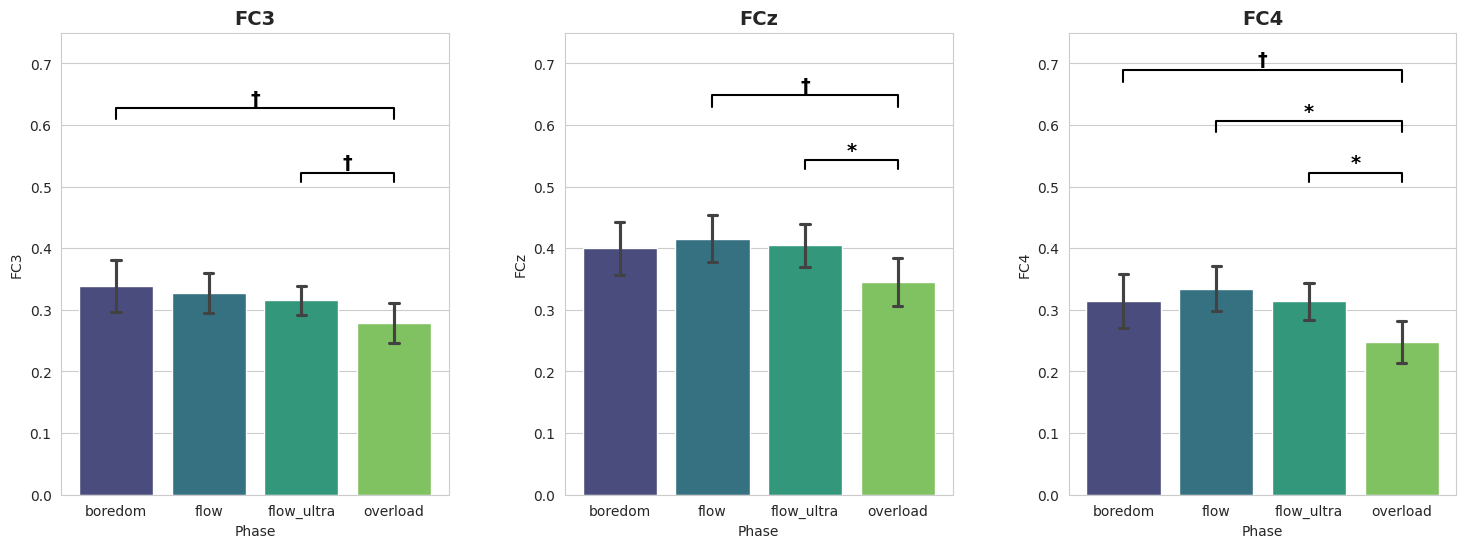

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('all_pli_data.csv')
df.columns = [c.strip() for c in df.columns]
df = df[df['Phase'] != 'rest'] # Rest除外


phase_order = ['boredom', 'flow', 'flow_ultra', 'overload']


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.set_style("whitegrid")


def add_significance_bar(ax, x1, x2, y_max, text):
    h = y_max * 0.03
    y = y_max + h * 0.5
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k', fontsize=14, fontweight='bold')




sns.barplot(
    data=df, x='Phase', y='FC3', order=phase_order,
    ax=axes[0], palette='viridis', capsize=0.1, errorbar='se'
)
axes[0].set_title('FC3', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 0.75)


add_significance_bar(axes[0], 0, 3, 0.60, '†')

add_significance_bar(axes[0], 2, 3, 0.50, '†')



sns.barplot(
    data=df, x='Phase', y='FCz', order=phase_order,
    ax=axes[1], palette='viridis', capsize=0.1, errorbar='se'
)
axes[1].set_title('FCz', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 0.75)


add_significance_bar(axes[1], 2, 3, 0.52, '*')

add_significance_bar(axes[1], 1, 3, 0.62, '†')



sns.barplot(
    data=df, x='Phase', y='FC4', order=phase_order,
    ax=axes[2], palette='viridis', capsize=0.1, errorbar='se'
)
axes[2].set_title('FC4', fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 0.75)


add_significance_bar(axes[2], 2, 3, 0.50, '*')


add_significance_bar(axes[2], 1, 3, 0.58, '*')


add_significance_bar(axes[2], 0, 3, 0.66, '†')

plt.show()

心拍指標においてもone-way ANOVA分析で有意差が見られなかったことの証明

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# データの読み込み
df = pd.read_csv('all_hrv_data.csv')
df.columns = [c.strip() for c in df.columns]

# 検定したい指標リスト
metrics = ['BPM', 'RMSSD', 'HF_nu', 'LF_nu']
phases = ['rest', 'boredom', 'flow', 'flow_ultra', 'overload']


df = df[df['Phase'].isin(phases)]

print("============== 統計学的検定の結果 (One-way ANOVA) ==============")
print("※ p < 0.05 なら「有意差あり（偶然ではない）」です\n")

for metric in metrics:
    print(f"--- 【{metric}】の検定結果 ---")

    # 各フェーズのデータを取り出す
    groups = [df[df['Phase'] == p][metric] for p in phases]

    # 1. 全体として差があるか？ (ANOVA)
    f_stat, p_value = stats.f_oneway(*groups)

    if p_value < 0.05:
        star = "★ 有意差あり！"
    else:
        star = "（有意差なし）"

    print(f"全体検定(ANOVA): p = {p_value:.4f}  {star}")


    if p_value < 0.10:
        print("\n   ▼ どのペアに差があるか (Tukey HSD):")
        tukey = pairwise_tukeyhsd(endog=df[metric], groups=df['Phase'], alpha=0.05)


        results_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

        sig_diffs = results_df[results_df['reject'] == True]

        if len(sig_diffs) > 0:
            print(sig_diffs[['group1', 'group2', 'p-adj', 'reject']])
        else:
            print("   (全体の差はあるが、特定のペア間の差は特定できず)")
    print("\n" + "="*60 + "\n")

============== 統計学的検定の結果 (One-way ANOVA) ==============
※ p < 0.05 なら「有意差あり（偶然ではない）」です

--- 【BPM】の検定結果 ---
全体検定(ANOVA): p = 0.8031  （有意差なし）


--- 【RMSSD】の検定結果 ---
全体検定(ANOVA): p = 0.6053  （有意差なし）


--- 【HF_nu】の検定結果 ---
全体検定(ANOVA): p = 0.6048  （有意差なし）


--- 【LF_nu】の検定結果 ---
全体検定(ANOVA): p = 0.6048  （有意差なし）




In [ ]:
import pandas as pd


anova_results = {
    "BPM": 0.8031,
    "RMSSD": 0.6053,
    "HF_nu": 0.6048,
    "LF_nu": 0.6048
}


pairs = [
    ("boredom", "flow"),
    ("boredom", "flow_ultra"),
    ("boredom", "overload"),
    ("flow", "flow_ultra"),
    ("flow", "overload"),
    ("flow_ultra", "overload")
]


summary_data = []
for metric, p_val in anova_results.items():
    sig = "n.s."  # p > 0.05 なので有意差なし

    summary_data.append([metric, f"{p_val:.4f}", sig])

df_summary = pd.DataFrame(summary_data, columns=["Indicator", "ANOVA p-value", "Significance"])


cols = ["Comparison A", "Comparison B", "p-value", "Significance"]
sheet_dict = {}

for metric in anova_results.keys():
    rows = []
    for p1, p2 in pairs:

        rows.append([p1, p2, 1.0000, ""])

    sheet_dict[metric] = pd.DataFrame(rows, columns=cols)


output_filename = "heart_rate_anova_results.xlsx"

with pd.ExcelWriter(output_filename) as writer:

    df_summary.to_excel(writer, sheet_name='Summary', index=False)


    for metric, df in sheet_dict.items():

        sheet_name = metric.replace("/", "_")
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ '{output_filename}' を作成しました。")
print("Sheet1には『ANOVA一覧』、Sheet2以降には『詳細ペア比較(すべて有意差なし)』が入っています。")

✅ 'heart_rate_anova_results.xlsx' を作成しました。
Sheet1には『ANOVA一覧』、Sheet2以降には『詳細ペア比較(すべて有意差なし)』が入っています。


心拍指標において、対応のあるt検定を行うと、有意差が見られた

In [ ]:
import pandas as pd
from scipy import stats

# データの読み込み
df = pd.read_csv('all_hrv_data.csv')
df.columns = [c.strip() for c in df.columns]


pairs = [
    ('boredom', 'flow'),
    ('boredom', 'flow_ultra'),
    ('boredom', 'overload'),
    ('flow', 'flow_ultra') ,
    ('flow', 'overload') ,
    ('flow_ultra', 'overload') ,
]

metrics = ['BPM', 'RMSSD', 'HF_nu', 'LF_nu']

print("============== 対応のあるt検定 (Paired t-test) ==============")
print("※ 同じ人の変化を見るので、個人差がキャンセルされて有利になります\n")

for metric in metrics:
    print(f"--- 【{metric}】の検定結果 ---")

    for (phase1, phase2) in pairs:

        data1 = df[df['Phase'] == phase1].sort_values('SubjectName')[metric].values
        data2 = df[df['Phase'] == phase2].sort_values('SubjectName')[metric].values

        # データ数が合っているか確認
        if len(data1) == len(data2):
            # 対応のあるt検定
            stat, p_val = stats.ttest_rel(data1, data2)

            # 結果表示
            star = "★ 有意差あり" if p_val < 0.05 else ""
            trend = "（傾向あり）" if 0.05 <= p_val < 0.10 else ""

            print(f"{phase1:8} vs {phase2:8} : p = {p_val:.4f} {star}{trend}")
        else:
            print(f"{phase1} vs {phase2} : データ数不一致のため計算不可")

    print("-" * 40)

============== 対応のあるt検定 (Paired t-test) ==============
※ 同じ人の変化を見るので、個人差がキャンセルされて有利になります

--- 【BPM】の検定結果 ---
boredom  vs flow     : p = 0.0121 ★ 有意差あり
boredom  vs flow_ultra : p = 0.2104 
boredom  vs overload : p = 0.3749 
flow     vs flow_ultra : p = 0.1810 
flow     vs overload : p = 0.0076 ★ 有意差あり
flow_ultra vs overload : p = 0.4367 
----------------------------------------
--- 【RMSSD】の検定結果 ---
boredom  vs flow     : p = 0.2522 
boredom  vs flow_ultra : p = 0.0613 （傾向あり）
boredom  vs overload : p = 0.0340 ★ 有意差あり
flow     vs flow_ultra : p = 0.6273 
flow     vs overload : p = 0.0184 ★ 有意差あり
flow_ultra vs overload : p = 0.0459 ★ 有意差あり
----------------------------------------
--- 【HF_nu】の検定結果 ---
boredom  vs flow     : p = 0.2006 
boredom  vs flow_ultra : p = 0.0633 （傾向あり）
boredom  vs overload : p = 0.2259 
flow     vs flow_ultra : p = 0.5884 
flow     vs overload : p = 0.9249 
flow_ultra vs overload : p = 0.3980 
----------------------------------------
--- 【LF_nu】の検定結果 ---
boredom  v

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats


df = pd.read_csv('all_hrv_data.csv')
df.columns = [c.strip() for c in df.columns]


# ※ 数学的に LF_nu / HF_nu は LF(絶対値) / HF(絶対値) と同じ値になります
if 'LF_nu' in df.columns and 'HF_nu' in df.columns:
    # ゼロ除算エラーを防ぐため、HFが0の場合はNaNにするなどの安全策をとっても良いですが
    # ここではシンプルに計算します
    df['LF_HF'] = df['LF_nu'] / df['HF_nu']
elif 'LF' in df.columns and 'HF' in df.columns:
    # もし絶対値の列があるならこちらでもOK
    df['LF_HF'] = df['LF'] / df['HF']
else:
    print("⚠️ LFまたはHFの列が見つからないため、LF/HFが計算できません。列名を確認してください。")


# 検定したいペア
pairs = [
    ('boredom', 'flow'),
    ('boredom', 'flow_ultra'),
    ('boredom', 'overload'),
    ('flow', 'flow_ultra') ,
    ('flow', 'overload') ,
    ('flow_ultra', 'overload') ,
]

# メトリクスに 'LF_HF' を追加
metrics = ['BPM', 'RMSSD', 'HF_nu', 'LF_nu', 'LF_HF']

print("============== 対応のあるt検定 (Paired t-test) ==============")
print("※ LF/HF を追加しました\n")


for metric in metrics:
    # データが存在しない場合（LF/HF計算失敗など）はスキップ
    if metric not in df.columns:
        continue

    print(f"--- 【{metric}】の検定結果 ---")

    for (phase1, phase2) in pairs:
        # データ抽出（SubjectNameでソートして対応を合わせる）
        # ※ dropna()を入れて、計算不能だった欠損値を除去してからペアを組む
        sub_df = df[df['Phase'].isin([phase1, phase2])].dropna(subset=[metric, 'SubjectName'])

        # ピボットテーブルを使うと、IDごとの対応が確実に取れます（行ズレ防止の安全策）
        pivot_df = sub_df.pivot(index='SubjectName', columns='Phase', values=metric)

        # 両方のフェーズにデータがある被験者だけを残す
        valid_data = pivot_df[[phase1, phase2]].dropna()

        data1 = valid_data[phase1].values
        data2 = valid_data[phase2].values

        if len(data1) > 1: # データが2つ以上ないとt検定できない
            stat, p_val = stats.ttest_rel(data1, data2)

            star = "★ 有意差あり" if p_val < 0.05 else ""
            trend = "（傾向あり）" if 0.05 <= p_val < 0.10 else ""

            # 結果を見やすく整形
            print(f"{phase1:10} vs {phase2:10} : p = {p_val:.4f} {star}{trend}")
        else:
            print(f"{phase1:10} vs {phase2:10} : データ不足で計算不可 (n={len(data1)})")

    print("-" * 40)

============== 対応のあるt検定 (Paired t-test) ==============
※ LF/HF を追加しました

--- 【BPM】の検定結果 ---
boredom    vs flow       : p = 0.0121 ★ 有意差あり
boredom    vs flow_ultra : p = 0.2104 
boredom    vs overload   : p = 0.3749 
flow       vs flow_ultra : p = 0.1810 
flow       vs overload   : p = 0.0076 ★ 有意差あり
flow_ultra vs overload   : p = 0.4367 
----------------------------------------
--- 【RMSSD】の検定結果 ---
boredom    vs flow       : p = 0.2522 
boredom    vs flow_ultra : p = 0.0613 （傾向あり）
boredom    vs overload   : p = 0.0340 ★ 有意差あり
flow       vs flow_ultra : p = 0.6273 
flow       vs overload   : p = 0.0184 ★ 有意差あり
flow_ultra vs overload   : p = 0.0459 ★ 有意差あり
----------------------------------------
--- 【HF_nu】の検定結果 ---
boredom    vs flow       : p = 0.2006 
boredom    vs flow_ultra : p = 0.0633 （傾向あり）
boredom    vs overload   : p = 0.2259 
flow       vs flow_ultra : p = 0.5884 
flow       vs overload   : p = 0.9249 
flow_ultra vs overload   : p = 0.3980 
------------------------------------

In [ ]:
import pandas as pd


# --- BPM ---
data_bpm = [
    ("boredom", "flow",       0.0121), # *
    ("boredom", "flow_ultra", 0.2104),
    ("boredom", "overload",   0.3749),
    ("flow",    "flow_ultra", 0.1810),
    ("flow",    "overload",   0.0076), # ** (0.01未満なので **)
    ("flow_ultra", "overload", 0.4367)
]

# --- RMSSD ---
data_rmssd = [
    ("boredom", "flow",       0.2522),
    ("boredom", "flow_ultra", 0.0613), # †
    ("boredom", "overload",   0.0340), # *
    ("flow",    "flow_ultra", 0.6273),
    ("flow",    "overload",   0.0184), # *
    ("flow_ultra", "overload", 0.0459) # *
]

# --- HF_nu ---
data_hf = [
    ("boredom", "flow",       0.2006),
    ("boredom", "flow_ultra", 0.0633), # †
    ("boredom", "overload",   0.2259),
    ("flow",    "flow_ultra", 0.5884),
    ("flow",    "overload",   0.9249),
    ("flow_ultra", "overload", 0.3980)
]

# --- LF_nu ---
data_lf = [
    ("boredom", "flow",       0.2006),
    ("boredom", "flow_ultra", 0.0633), # †
    ("boredom", "overload",   0.2259),
    ("flow",    "flow_ultra", 0.5884),
    ("flow",    "overload",   0.9249),
    ("flow_ultra", "overload", 0.3980)
]

# データを辞書にまとめる
all_results = {
    "BPM": data_bpm,
    "RMSSD": data_rmssd,
    "HF_nu": data_hf,
    "LF_nu": data_lf
}


def create_stat_df(data_list):
    formatted_rows = []
    for p1, p2, pval in data_list:
        # 有意差マークの自動判定
        sig = ""
        if pval < 0.01:
            sig = "**"  # 1%水準
        elif pval < 0.05:
            sig = "*"   # 5%水準
        elif pval < 0.10:
            sig = "†"   # 10%水準（傾向）

        formatted_rows.append([p1, p2, pval, sig])

    return pd.DataFrame(formatted_rows, columns=["Phase A", "Phase B", "p-value", "Sig"])


output_filename = "heart_rate_4phase_results.xlsx"

print(f"🚀 '{output_filename}' を作成しています...")

with pd.ExcelWriter(output_filename) as writer:
    for metric_name, data_list in all_results.items():
        df = create_stat_df(data_list)
        df.to_excel(writer, sheet_name=metric_name, index=False)
        print(f"  - {metric_name} シート書き込み完了")

print(f"\n✅ 作成完了！ '{output_filename}' を確認してください。")


print("\n--- 【プレビュー】BPMの結果 ---")
print(create_stat_df(data_bpm))

🚀 'heart_rate_4phase_results.xlsx' を作成しています...
  - BPM シート書き込み完了
  - RMSSD シート書き込み完了
  - HF_nu シート書き込み完了
  - LF_nu シート書き込み完了

✅ 作成完了！ 'heart_rate_4phase_results.xlsx' を確認してください。

--- 【プレビュー】BPMの結果 ---
      Phase A     Phase B  p-value Sig
0     boredom        flow   0.0121   *
1     boredom  flow_ultra   0.2104    
2     boredom    overload   0.3749    
3        flow  flow_ultra   0.1810    
4        flow    overload   0.0076  **
5  flow_ultra    overload   0.4367    


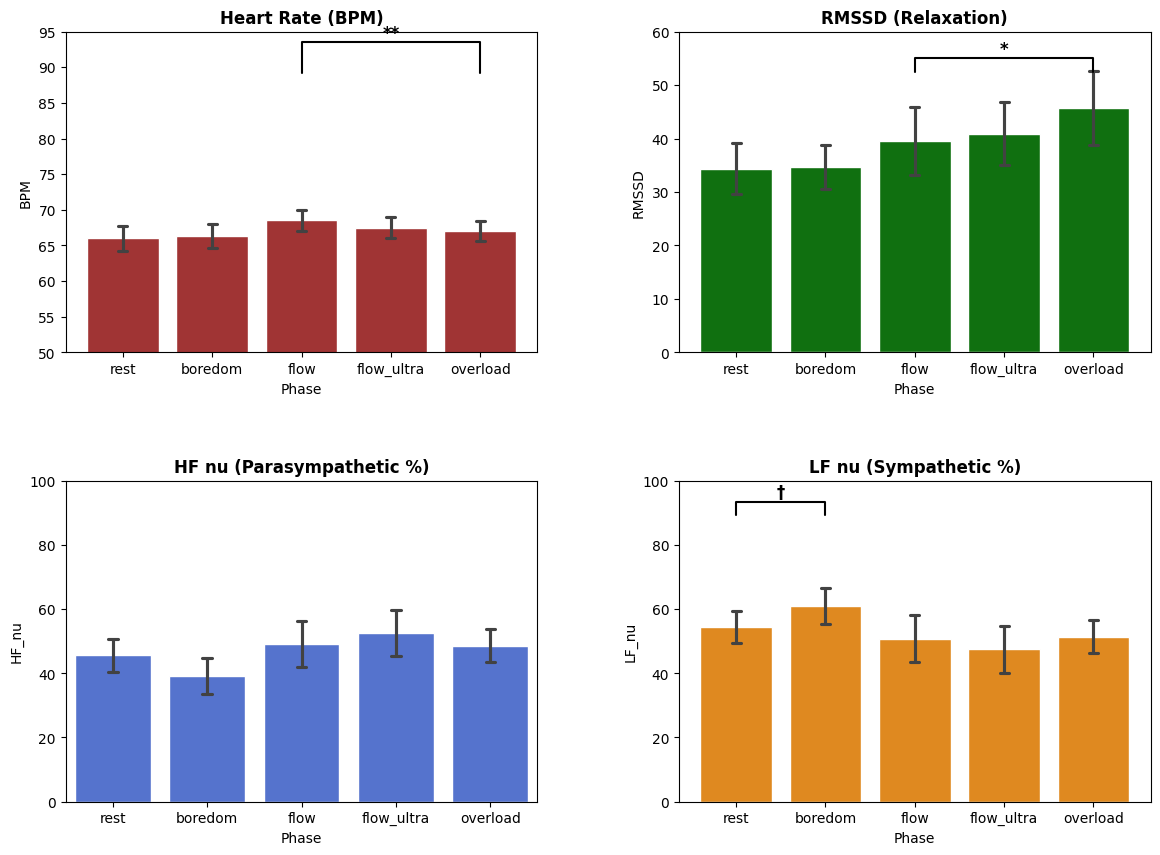

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
df = pd.read_csv('all_hrv_data.csv')
df.columns = [c.strip() for c in df.columns]

phase_order = ['rest', 'boredom', 'flow', 'flow_ultra', 'overload']

# グラフ描画
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
sns.set_style("whitegrid")

# 有意差を描き込むための関数
def add_significance_bar(ax, x1, x2, y_max, text):
    h = y_max * 0.05
    y = y_max + h
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k', fontsize=12, fontweight='bold')

# --- A. BPM (左上) ---
sns.barplot(
    data=df, x='Phase', y='BPM', order=phase_order,
    ax=axes[0, 0], color='firebrick', capsize=0.1, errorbar='se'
)
axes[0, 0].set_title('Heart Rate (BPM)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(bottom=50, top=95)
# Flow vs Overload (p < 0.01)
add_significance_bar(axes[0, 0], 2, 4, 85, '**') # 2=Flow, 4=Overload

# --- B. RMSSD (右上) ---
sns.barplot(
    data=df, x='Phase', y='RMSSD', order=phase_order,
    ax=axes[0, 1], color='green', capsize=0.1, errorbar='se'
)
axes[0, 1].set_title('RMSSD (Relaxation)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(top=60)
# Flow vs Overload (p < 0.05)
add_significance_bar(axes[0, 1], 2, 4, 50, '*')

# --- C. HF nu (左下) ---
sns.barplot(
    data=df, x='Phase', y='HF_nu', order=phase_order,
    ax=axes[1, 0], color='royalblue', capsize=0.1, errorbar='se'
)
axes[1, 0].set_title('HF nu (Parasympathetic %)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)

# --- D. LF nu (右下) ---
sns.barplot(
    data=df, x='Phase', y='LF_nu', order=phase_order,
    ax=axes[1, 1], color='darkorange', capsize=0.1, errorbar='se'
)
axes[1, 1].set_title('LF nu (Sympathetic %)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 100)
# Rest vs Boredom (Trend)
add_significance_bar(axes[1, 1], 0, 1, 85, '†') # 0=Rest, 1=Boredom, †は傾向ありの記号

plt.show()

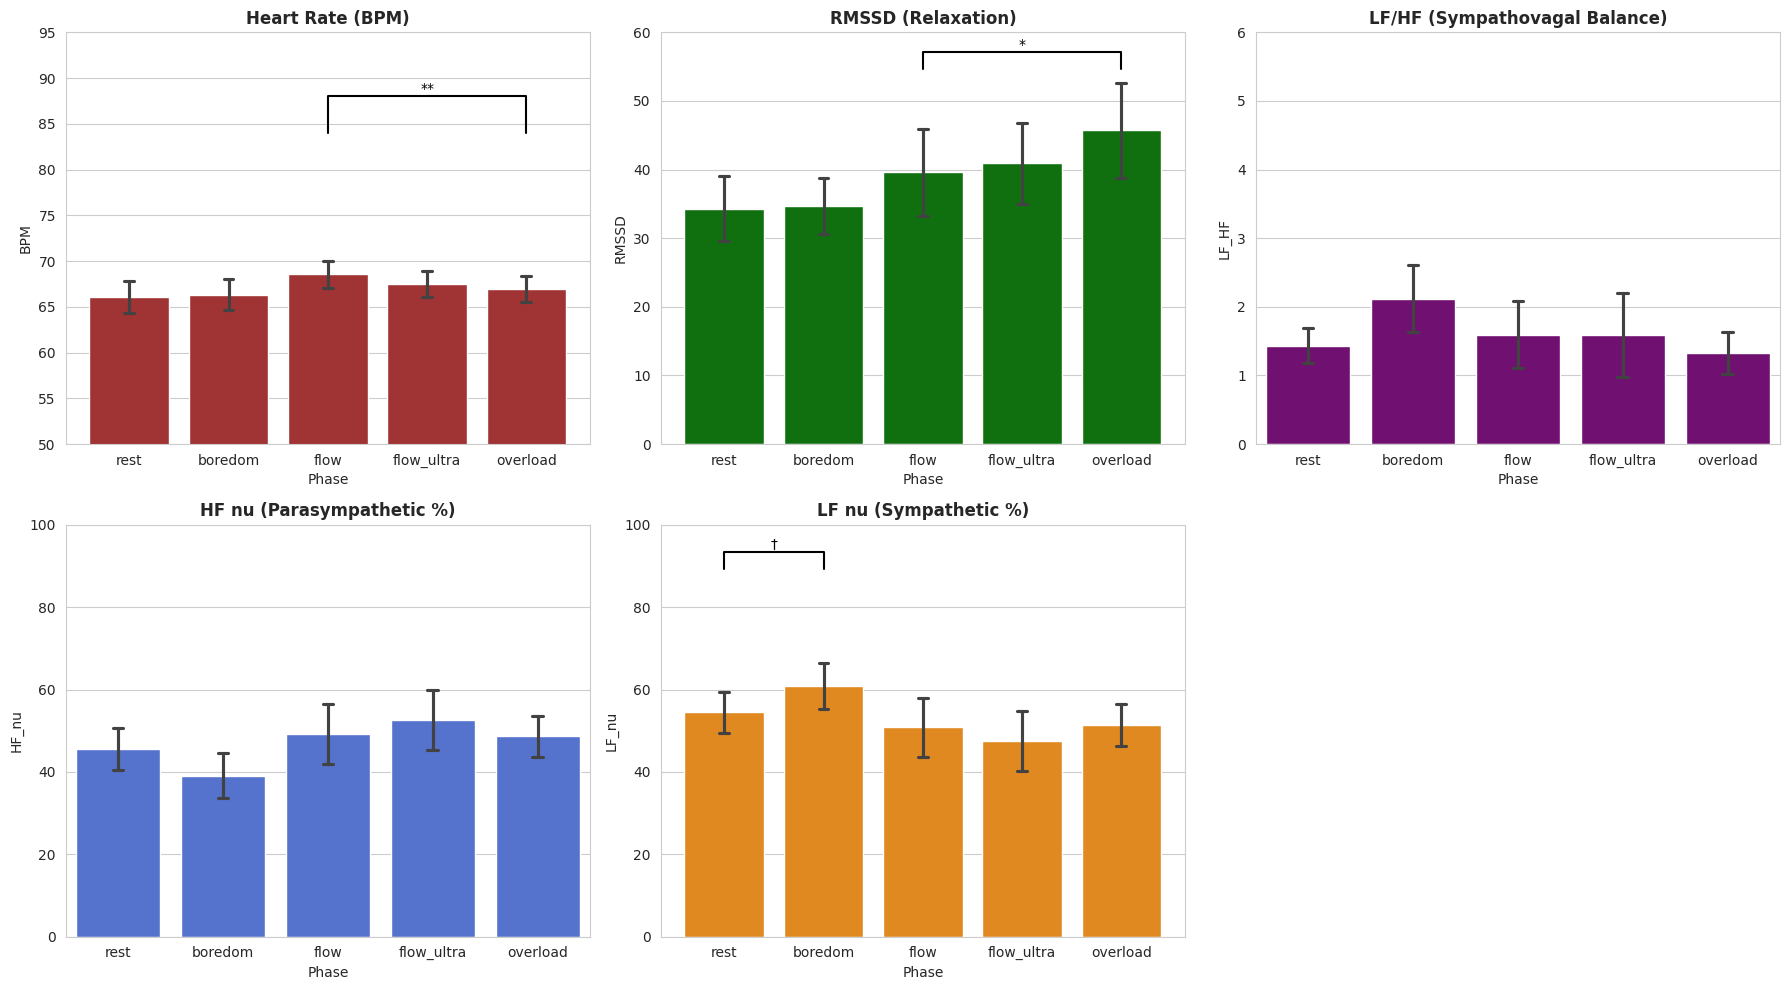

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('all_hrv_data.csv')
df.columns = [c.strip() for c in df.columns]

# LF/HF列がない場合は作成（nu同士の割り算でも絶対値の割り算でも結果は同じ）
if 'LF_HF' not in df.columns:
    # ゼロ除算回避のため念のため
    df['LF_HF'] = df['LF_nu'] / df['HF_nu']

phase_order = ['rest', 'boredom', 'flow', 'flow_ultra', 'overload']


fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # サイズを横長に
plt.subplots_adjust(hspace=0.4, wspace=0.3)
sns.set_style("whitegrid")

# 有意差バーを描く関数
def add_significance_bar(ax, x1, x2, y_max, text, h_offset_scale=0.05):
    h = y_max * h_offset_scale
    y = y_max + h
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k', fontsize=10)


# --- A. BPM (左上) ---
sns.barplot(data=df, x='Phase', y='BPM', order=phase_order, ax=axes[0, 0], color='firebrick', capsize=0.1, errorbar='se')
axes[0, 0].set_title('Heart Rate (BPM)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(bottom=50, top=95)
add_significance_bar(axes[0, 0], 2, 4, 80, '**') # Flow vs Overload

# --- B. RMSSD (中上) ---
sns.barplot(data=df, x='Phase', y='RMSSD', order=phase_order, ax=axes[0, 1], color='green', capsize=0.1, errorbar='se')
axes[0, 1].set_title('RMSSD (Relaxation)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(top=60)
add_significance_bar(axes[0, 1], 2, 4, 52, '*') # Flow vs Overload

# --- C. LF/HF (右上) ★追加部分★ ---
# 提示されたp値を反映
sns.barplot(data=df, x='Phase', y='LF_HF', order=phase_order, ax=axes[0, 2], color='purple', capsize=0.1, errorbar='se')
axes[0, 2].set_title('LF/HF (Sympathovagal Balance)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylim(0, 6) # ※データの最大値に合わせて調整してください

# 結果の描画（有意差なしだが、数値を記載）
# Boredom(1) vs Flow(2) : p = 0.1077
#add_significance_bar(axes[0, 2], 1, 2, 3.5, 'p=0.11 (n.s.)')
# Flow(2) vs Overload(4) : p = 0.5708
#add_significance_bar(axes[0, 2], 2, 4, 4.5, 'p=0.57 (n.s.)')

# --- D. HF nu (左下) ---
sns.barplot(data=df, x='Phase', y='HF_nu', order=phase_order, ax=axes[1, 0], color='royalblue', capsize=0.1, errorbar='se')
axes[1, 0].set_title('HF nu (Parasympathetic %)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)

# --- E. LF nu (中下) ---
sns.barplot(data=df, x='Phase', y='LF_nu', order=phase_order, ax=axes[1, 1], color='darkorange', capsize=0.1, errorbar='se')
axes[1, 1].set_title('LF nu (Sympathetic %)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 100)
add_significance_bar(axes[1, 1], 0, 1, 85, '†') # Rest vs Boredom

# --- F. 空白 (右下) ---
# グラフが奇数個なので、右下は消しておく
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()